In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -uq "drive/My Drive/mercari-price-suggestion-challenge.zip" -d "drive/My Drive/mercari-price-suggestion-challenge"

In [3]:
!7z x '/content/drive/My Drive/mercari-price-suggestion-challenge/*.7z'
!unzip '/content/drive/My Drive/mercari-price-suggestion-challenge/*.zip'


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/My Drive/mercari-price-suggestion-challenge/                                                                     3 files, 113703433 bytes (109 MiB)
  0%    
Extracting archive: /content/drive/My Drive/mercari-price-suggestion-challenge/sample_submission.csv.7z
--
Path = /content/drive/My Drive/mercari-price-suggestion-challenge/sample_submission.csv.7z
Type = 7z
Physical Size = 174228
Headers Size = 143
Method = LZMA:12m
Solid = -
Blocks = 1

  0%    Everything is Ok

Extracting archive: /content/drive/My Drive/mercari-price-suggestion-challenge/test.tsv.7z
--
Path = /content/drive/M

In [2]:
ls

drive/        sample_submission.csv       test_stg2.tsv  train.tsv
sample_data/  sample_submission_stg2.csv  test.tsv


In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
from sklearn.model_selection import train_test_split
pd.set_option('display.float_format', lambda x:'%.5f' % x)
import numpy as np

In [4]:
# データタイプを指定
types_dict_train = {'train_id':'int64', 'item_condition_id':'int8', 'price':'float64', 'shipping':'int8'}
types_dict_test = {'test_id':'int64', 'item_condition_id':'int8', 'shipping':'int8'}
 
# tsvファイルからPandas DataFrameへ読み込み
train = pd.read_csv('train.tsv', delimiter='\t', low_memory=True, dtype=types_dict_train)
test = pd.read_csv('test.tsv', delimiter='\t', low_memory=True, dtype=types_dict_test)

In [5]:
# trainとtestのデータフレームの冒頭5行を表示させる
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.00000,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.00000,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.00000,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.00000,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.00000,0,Complete with certificate of authenticity


In [6]:
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [7]:
# trainとtestのサイズを確認
train.shape, test.shape

((1482535, 8), (693359, 7))

In [8]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000):
        with pd.option_context("display.max_columns", 1000):
            display(df)
 
# trainの基本統計量を表示
display_all(train.describe(include='all').transpose())

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
train_id,1482535.00000,NaN,NaN,NaN,741267.00000,427971.13500,0.00000,370633.50000,741267.00000,1111900.50000,1482534.00000
name,1482535,1225273,Bundle,2232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
item_condition_id,1482535.00000,NaN,NaN,NaN,1.90738,0.90316,1.00000,1.00000,2.00000,3.00000,5.00000
category_name,1476208,1287,"Women/Athletic Apparel/Pants, Tights, Leggings",60177,NaN,NaN,NaN,NaN,NaN,NaN,NaN
brand_name,849853,4809,PINK,54088,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,1482535.00000,NaN,NaN,NaN,26.73752,38.58607,0.00000,10.00000,17.00000,29.00000,2009.00000
shipping,1482535.00000,NaN,NaN,NaN,0.44727,0.49721,0.00000,0.00000,0.00000,1.00000,1.00000
item_description,1482531,1281426,No description yet,82489,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# trainのカテゴリ名、商品説明、投稿タイトル、ブランド名のデータタイプを「category」へ変換する
train.category_name = train.category_name.astype('category')
train.item_description = train.item_description.astype('category')
train.name = train.name.astype('category')
train.brand_name = train.brand_name.astype('category')
 
# testのカテゴリ名、商品説明、投稿タイトル、ブランド名のデータタイプを「category」へ変換する
test.category_name = test.category_name.astype('category')
test.item_description = test.item_description.astype('category')
test.name = test.name.astype('category')
test.brand_name = test.brand_name.astype('category')
 
# dtypesで念のためデータ形式を確認しましょう
train.dtypes, test.dtypes

(train_id                int64
 name                 category
 item_condition_id        int8
 category_name        category
 brand_name           category
 price                 float64
 shipping                 int8
 item_description     category
 dtype: object, test_id                 int64
 name                 category
 item_condition_id        int8
 category_name        category
 brand_name           category
 shipping                 int8
 item_description     category
 dtype: object)

In [10]:
# trainの中のユニークな値を確認する
print(train.apply(lambda x: x.nunique()))
 
# testの中のユニークな値を確認する
test.apply(lambda x: x.nunique())

train_id             1482535
name                 1225273
item_condition_id          5
category_name           1287
brand_name              4809
price                    828
shipping                   2
item_description     1281426
dtype: int64


test_id              693359
name                 601117
item_condition_id         5
category_name          1223
brand_name             3900
shipping                  2
item_description     609555
dtype: int64

In [11]:
# trainの欠損データの個数と%を確認
train.isnull().sum(),train.isnull().sum()/train.shape[0]
 
# testの欠損データの個数と%を確認
test.isnull().sum(),test.isnull().sum()/test.shape[0]

(test_id                   0
 name                      0
 item_condition_id         0
 category_name          3058
 brand_name           295525
 shipping                  0
 item_description          0
 dtype: int64, test_id             0.00000
 name                0.00000
 item_condition_id   0.00000
 category_name       0.00441
 brand_name          0.42622
 shipping            0.00000
 item_description    0.00000
 dtype: float64)

In [12]:
# trainとtestのidカラム名を変更する
train = train.rename(columns = {'train_id':'id'})
test = test.rename(columns = {'test_id':'id'})
 
# 両方のセットへ「is_train」のカラムを追加
# 1 = trainのデータ、0 = testデータ
train['is_train'] = 1
test['is_train'] = 0

# trainのprice(価格）以外のデータをtestと連結
train_test_combine = pd.concat([train.drop(['price'], axis=1),test],axis=0)

train_test_combine.head()

,id,name,item_condition_id,category_name,brand_name,shipping,item_description,is_train
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,1,No description yet,1
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,0,This keyboard is in great condition and works ...,1
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,1,Adorable top with a hint of lace and a key hol...,1
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,1,New with tags. Leather horses. Retail for [rm]...,1
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,0,Complete with certificate of authenticity,1


In [13]:
train_test_combine.dtypes

id                    int64
name                 object
item_condition_id      int8
category_name        object
brand_name           object
shipping               int8
item_description     object
is_train              int64
dtype: object

In [14]:
# reference: BuryBuryZymon at https://www.kaggle.com/maheshdadhich/i-will-sell-everything-for-free-0-55
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")

a,b,c=zip(*train_test_combine['category_name'].apply(lambda x: split_cat(x)))
train_test_combine['general_cat']=a
train_test_combine['subcat_1']=b
train_test_combine['subcat_2']=c

In [15]:
def wordCount(text):
    # convert to lower case and strip regex
    try:
         # convert to lower case and strip regex
        text = text.lower()
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        txt = regex.sub(" ", text)
        # tokenize
        # words = nltk.word_tokenize(clean_txt)
        # remove words in stop words
        words = [w for w in txt.split(" ") \
                 if not w in stop_words.ENGLISH_STOP_WORDS and len(w)>3]
        return len(words)
    except: 
        return 0

# add a column of word counts to both the training and test set
train_test_combine['desc_len'] = train_test_combine['item_description'].apply(lambda x: wordCount(x))

In [16]:
general_cats = train_test_combine['general_cat'].unique()

In [17]:
general_cats

array(['Men', 'Electronics', 'Women', 'Home', 'Sports & Outdoors',
       'Vintage & Collectibles', 'Beauty', 'Other', 'Kids', 'No Label',
       'Handmade'], dtype=object)

In [18]:
# Experiment for understanding
import re
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords

operators = ['+', '-', '*', '/', '**']
regex =re.compile('[' + re.escape(re.sub('\'', '', string.punctuation)) + '0-9\\r\\t\\n]')
regex =re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
print('　@'.join(map(re.escape, operators)))
print(re.escape(operators[1]))
print(string.punctuation)
text = re.sub('\'', '', string.punctuation) + "At eight o'clock on Thursday morning, Arthur didn't feel very good."
text = regex.sub(" ", text) # 置換 replace
print(text)
tokens_ = [word_tokenize(s) for s in sent_tokenize(text)]
print(tokens_)
tokens = []
for token_by_sent in tokens_:
    tokens += token_by_sent
print(tokens)
stop = set(stopwords.words('english'))
filtered_tokens = list(filter(lambda t: t.lower() not in stop, tokens))
print(filtered_tokens)
filtered_tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
print(filtered_tokens)
filtered_tokens = [w.lower() for w in tokens if len(w)>=3]
print(filtered_tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
\+　@\-　@\*　@\/　@\*\*
\-
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
                               At eight o clock on Thursday morning  Arthur didn t feel very good 
[['At', 'eight', 'o', 'clock', 'on', 'Thursday', 'morning', 'Arthur', 'didn', 't', 'feel', 'very', 'good']]
['At', 'eight', 'o', 'clock', 'on', 'Thursday', 'morning', 'Arthur', 'didn', 't', 'feel', 'very', 'good']
['eight', 'clock', 'Thursday', 'morning', 'Arthur', 'feel', 'good']
['At', 'eight', 'o', 'clock', 'on', 'Thursday', 'morning', 'Arthur', 'didn', 't', 'feel', 'very', 'good']
['eight', 'clock', 'thursday', 'morning', 'arthur', 'didn', 'feel', 'very', 'good']


In [19]:
import string
import nltk

nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction import stop_words

stop = set(stopwords.words('english'))

def tokenize(text):
    """
    sent_tokenize(): segment text into sentences
    word_tokenize(): break sentences into words
    """
    try: 
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        text = regex.sub(" ", text) # remove punctuation
        
        tokens_ = [word_tokenize(s) for s in sent_tokenize(text)]
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent
        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        filtered_tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
        filtered_tokens = [w.lower() for w in filtered_tokens if len(w)>=3]
        
        return filtered_tokens
            
    except TypeError as e: print(text,e)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [20]:
# remove missing values in item description
train_test_combine = train_test_combine[pd.notnull(train_test_combine['item_description'])]

In [21]:
# apply the tokenizer into the item descriptipn column
train_test_combine['tokens'] = train_test_combine['item_description'].map(tokenize)
train_test_combine['tokens']

0                                        [description, yet]
1         [keyboard, great, condition, works, like, came...
2         [adorable, top, hint, lace, key, hole, back, p...
3         [new, tags, leather, horses, retail, stand, fo...
4                     [complete, certificate, authenticity]
                                ...                        
693354    [flint, quartz, cluster, self, mined, ✨measure...
693355    [cosmetics, travel, bundle, includes, brow, po...
693356                 [new, free, shipping, basstop, case]
693357    [floral, kimono, tropical, print, open, front,...
693358    [floral, scrub, tops, worn, less, times, brown...
Name: tokens, Length: 2175890, dtype: object

In [22]:
# index（行名、行ラベル）を0始まりの連番（行番号）に振り直す
train_test_combine.reset_index(drop=True, inplace=True) 

In [23]:
for description, tokens in zip(train_test_combine['item_description'].head(),
                              train_test_combine['tokens'].head()):
    print('description:', description)
    print('tokens:', tokens)

description: No description yet
tokens: ['description', 'yet']
description: This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
tokens: ['keyboard', 'great', 'condition', 'works', 'like', 'came', 'box', 'ports', 'tested', 'work', 'perfectly', 'lights', 'customizable', 'via', 'razer', 'synapse', 'app']
description: Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!
tokens: ['adorable', 'top', 'hint', 'lace', 'key', 'hole', 'back', 'pale', 'pink', 'also', 'available', 'white']
description: New with tags. Leather horses. Retail for [rm] each. Stand about a foot high. They are being sold as a pair. Any questions please ask. Free shipping. Just got out of storage
tokens: ['new', 'tags', 'leather', 'horses', 'retail', 'stand', 'foot', 'high', 'sold', 'pair', 'questions', 'please', 'as

In [24]:
train_test_combine

,id,name,item_condition_id,category_name,brand_name,shipping,item_description,is_train,general_cat,subcat_1,subcat_2,desc_len,tokens
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,1,No description yet,1,Men,Tops,T-shirts,0,"[description, yet]"
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,0,This keyboard is in great condition and works ...,1,Electronics,Computers & Tablets,Components & Parts,0,"[keyboard, great, condition, works, like, came..."
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,1,Adorable top with a hint of lace and a key hol...,1,Women,Tops & Blouses,Blouse,0,"[adorable, top, hint, lace, key, hole, back, p..."
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,1,New with tags. Leather horses. Retail for [rm]...,1,Home,Home Décor,Home Décor Accents,0,"[new, tags, leather, horses, retail, stand, fo..."
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,0,Complete with certificate of authenticity,1,Women,Jewelry,Necklaces,0,"[complete, certificate, authenticity]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2175885,693354,Quartz crystal on Flint stone,1,Home/Home Décor/Home Décor Accents,NaN,0,Flint/Quartz cluster. Self mined ✨measures 3x2...,0,Home,Home Décor,Home Décor Accents,0,"[flint, quartz, cluster, self, mined, ✨measure..."
2175886,693355,It Cosmetics - Travel Bundle,1,Beauty/Makeup/Makeup Sets,IT Cosmetics,1,It Cosmetics travel bundle. Includes: Brow pow...,0,Beauty,Makeup,Makeup Sets,0,"[cosmetics, travel, bundle, includes, brow, po..."
2175887,693356,Galaxy S8 hard shell case,1,"Electronics/Cell Phones & Accessories/Cases, C...",NaN,1,New. Free shipping Basstop case,0,Electronics,Cell Phones & Accessories,"Cases, Covers & Skins",0,"[new, free, shipping, basstop, case]"
2175888,693357,Hi low floral kimono,2,Women/Swimwear/Cover-Ups,NaN,0,Floral kimono. Tropical print. Open front. Hi ...,0,Women,Swimwear,Cover-Ups,0,"[floral, kimono, tropical, print, open, front,..."


In [25]:
# Experiment for understanding
cat_desc = dict()
for cat in general_cats: 
    text = " ".join(str(train_test_combine.loc[train_test_combine['general_cat']==cat, 'item_description'].values))
    cat_desc[cat] = tokenize(text)
print(cat_desc)

{'Men': [], 'Electronics': [], 'Women': [], 'Home': [], 'Sports & Outdoors': [], 'Vintage & Collectibles': [], 'Beauty': [], 'Other': [], 'Kids': [], 'No Label': [], 'Handmade': []}


In [54]:
import collections

# build dictionary with key=category and values as all the descriptions related.
cat_desc = dict()
for cat in general_cats: 
    text = " ".join(train_test_combine.loc[train_test_combine['general_cat']==cat, 'item_description'].values)
    cat_desc[cat] = tokenize(text)

In [101]:
# find the most common words for the top 4 categories
women100 = collections.Counter(cat_desc['Women'])
beauty100 = collections.Counter(cat_desc['Beauty'])
kids100 = collections.Counter(cat_desc['Kids'])
electronics100 = collections.Counter(cat_desc['Electronics'])

In [130]:
# Experiments for understanding
women = collections.Counter(cat_desc['Women']).most_common(100) # not dict but list
woman1 = list(women100.keys())
woman2 = list(women100.values())
woman = pd.DataFrame([woman1, woman2]).T
woman.columns ={'counts', 'words'}
woman

,words,counts
0,adorable,7561
1,top,69192
2,hint,262
3,lace,27692
4,key,3081
...,...,...
83381,sarriano,1
83382,anan,1
83383,undead,1
83384,girliness,1


In [87]:
cat_desc

{'Beauty': ['full',
  'size',
  'sephora',
  'new',
  'pink',
  'body',
  'mists',
  'fresh',
  'clean',
  'sun',
  'kiss',
  'cool',
  'bright',
  'total',
  'flirt',
  'sweet',
  'flirty',
  'brand',
  'new',
  'deluxe',
  'travel',
  'size',
  'products',
  'contains',
  'amazonian',
  'clay',
  'hour',
  'blush',
  'paaarty',
  'tarteist',
  'lip',
  'paint',
  'birthday',
  'suit',
  'glitter',
  'eyeshadows',
  'one',
  'brass',
  'one',
  'bleached',
  'authentic',
  'pallete',
  'faced',
  'brand',
  'new',
  'mint',
  'condition',
  'still',
  'original',
  'box',
  'part',
  'christmas',
  'collection',
  'pretty',
  'eye',
  'shadow',
  'colors',
  'small',
  'sized',
  'better',
  'sex',
  'mascara',
  'never',
  'even',
  'swatched',
  'impeccable',
  'shape',
  'price',
  'includes',
  'day',
  'priority',
  'shipping',
  'insurance',
  'bnib',
  'better',
  'sex',
  'waterproof',
  'mascara',
  'travel',
  'size',
  'see',
  'posts',
  'new',
  'unused',
  'authentic',
 

In [69]:
women100

Counter({'adorable': 7561,
         'top': 69192,
         'hint': 262,
         'lace': 27692,
         'key': 3081,
         'hole': 4024,
         'back': 55094,
         'pale': 1298,
         'pink': 111096,
         'also': 22465,
         'available': 17849,
         'white': 67038,
         'complete': 1076,
         'certificate': 115,
         'authenticity': 1572,
         'banana': 1945,
         'republic': 2265,
         'bottoms': 9735,
         'candies': 333,
         'skirt': 13981,
         'matching': 5493,
         'blazer': 1637,
         'amy': 119,
         'byers': 2,
         'suit': 5210,
         'loft': 1392,
         'cami': 1226,
         'size': 424680,
         'small': 120894,
         'straps': 17456,
         'slightly': 6163,
         'shortened': 96,
         'fit': 67769,
         'besides': 1012,
         'perfect': 56352,
         'condition': 195221,
         'great': 100510,
         'authentic': 30523,
         'suede': 7640,
         'fringe

In [82]:
from wordcloud import WordCloud

def generate_wordcloud(tup):
    d = {}
    for a, x in tup.most_common(100):
        d[a] = x
    wordcloud = WordCloud(background_color='black',
                          max_words=100, max_font_size=40,
                          random_state=42
                         ).generate_from_frequencies(frequencies=d)
    return wordcloud

Text(0.5, 1.0, 'Electronic Top 100')

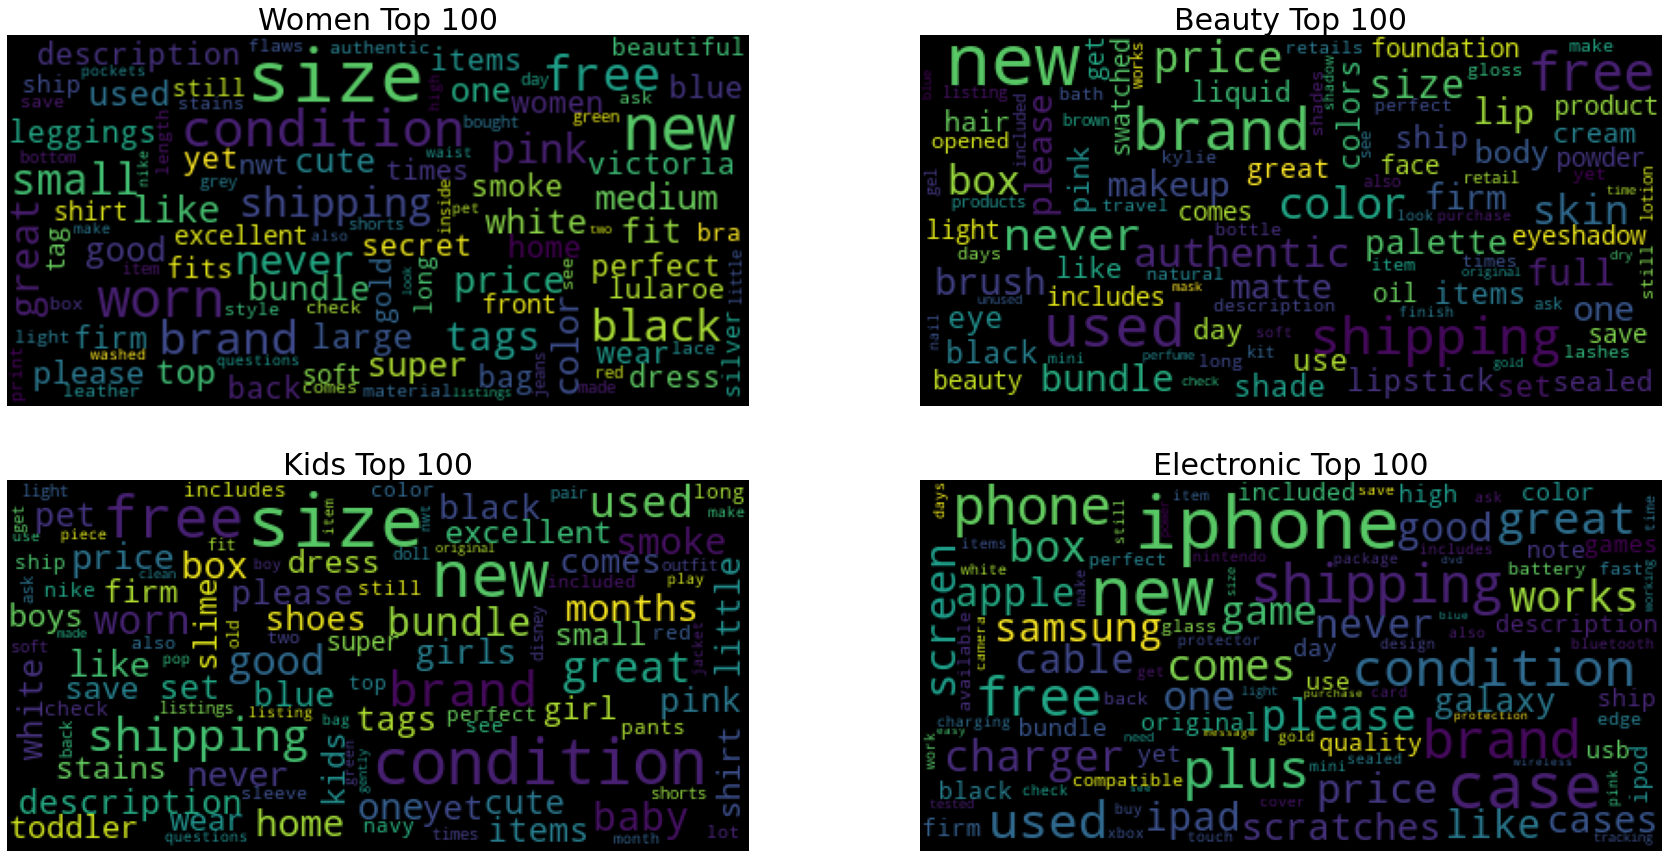

In [83]:
import matplotlib.pyplot as plt


fig,axes = plt.subplots(2, 2, figsize=(30, 15))

ax = axes[0, 0]
ax.imshow(generate_wordcloud(women100), interpolation="bilinear")
ax.axis('off')
ax.set_title("Women Top 100", fontsize=30)

ax = axes[0, 1]
ax.imshow(generate_wordcloud(beauty100))
ax.axis('off')
ax.set_title("Beauty Top 100", fontsize=30)

ax = axes[1, 0]
ax.imshow(generate_wordcloud(kids100))
ax.axis('off')
ax.set_title("Kids Top 100", fontsize=30)

ax = axes[1, 1]
ax.imshow(generate_wordcloud(electronics100))
ax.axis('off')
ax.set_title("Electronic Top 100", fontsize=30)

In [ ]:
# train_test_combineの文字列のデータタイプを「category」へ変換
train_test_combine.category_name = train_test_combine.category_name.astype('category')
train_test_combine.item_description = train_test_combine.item_description.astype('category')
train_test_combine.name = train_test_combine.name.astype('category')
train_test_combine.brand_name = train_test_combine.brand_name.astype('category')
 
# combinedDataの文字列を「.cat.codes」で数値へ変換する
train_test_combine.name = train_test_combine.name.cat.codes
train_test_combine.category_name = train_test_combine.category_name.cat.codes
train_test_combine.brand_name = train_test_combine.brand_name.cat.codes
train_test_combine.item_description = train_test_combine.item_description.cat.codes
 
# データの中身とデータ形式を表示して確認しましょう
print(train_test_combine.head())
print(train_test_combine.dtypes)

In [ ]:
# 「is_train」のフラグでcombineからtestとtrainへ切り分ける
df_test = train_test_combine.loc[train_test_combine['is_train'] == 0]
df_train = train_test_combine.loc[train_test_combine['is_train'] == 1]
 
# 「is_train」をtrainとtestのデータフレームから落とす
df_test = df_test.drop(['is_train'], axis=1)
df_train = df_train.drop(['is_train'], axis=1)
 
# サイズの確認をしておきましょう
df_test.shape, df_train.shape

In [ ]:
# df_trainへprice（価格）を戻す
df_train['price'] = train.price
 
# price（価格）をlog関数で処理
df_train['price'] = df_train['price'].apply(lambda x: np.log(x) if x>0 else x)
 
# df_trainを表示して確認
df_train.head()

In [ ]:
import seaborn as sns
sns.pairplot(df_train[["id", "name", "item_condition_id", "category_name", "brand_name", "shipping", "item_description", "price"]], diag_kind="kde")

In [ ]:
train_stats = df_train.describe()
train_stats.pop("price")
train_stats = train_stats.transpose()
train_stats

In [ ]:
test_stats = df_test.describe()
test_stats.pop("price")
test_stats = test_stats.transpose()

In [ ]:
def norm(x):
  return (x - test_stats['mean']) / test_stats['std']
df_test = norm(df_test)

In [ ]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
df_train = norm(df_train)

df_train['price'] = train.price
df_train['price'] = df_train['price'].apply(lambda x: np.log(x) if x>0 else x)

In [ ]:
# x ＝ price以外の全ての値、y = price（ターゲット）で切り分ける
x_train, y_train = df_train.drop(['price'], axis=1), df_train.price

In [ ]:
# prepare PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=6) # 5 components will be used
pca.fit(x_train) # obtain principal component
x_train_low = pca.transform(x_train) # transform input data using PCA

In [ ]:
# x ＝ price以外の全ての値、y = price（ターゲット）で切り分ける
x_train, y_train = df_train.drop(['price'], axis=1), df_train.price# モデルの作成
m = RandomForestRegressor(n_jobs=-1, min_samples_leaf=5, n_estimators=200)
m.fit(x_train_low, y_train)

In [ ]:
# スコアを表示
m.score(x_train_low, y_train)

In [ ]:
# 作成したランダムフォレストのモデル「m」に「df_test」を入れて予測する
preds = m.predict(df_test)
 
# 予測値 predsをnp.exp()で処理
np.exp(preds)
 
# Numpy配列からpandasシリーズへ変換
preds = pd.Series(np.exp(preds))
 
# テストデータのIDと予測値を連結
submit = pd.concat([df_test.id, preds], axis=1)
 
# カラム名をメルカリの提出指定の名前をつける
submit.columns = ['test_id', 'price']
 
# 提出ファイルとしてCSVへ書き出し
submit.to_csv('submit_rf_base.csv', index=False)